<a href="https://colab.research.google.com/github/wahid028/CryptoCurrency-Price-prediction_Kaggle/blob/main/GluonTS_Bitcoin_g_research_crypto_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Connecting colab with kaggle using kaggle API**

In [1]:
#install kaggle
!pip install -q kaggle

In [2]:
#upload the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"learn2know","key":"ef7c1f3683ce0590f0cee38b88d74d21"}'}

In [3]:
#create a kaggle directory
!mkdir ~/.kaggle

In [4]:
#copy the kaggle.json to kaggle directory
!cp kaggle.json ~/.kaggle/

In [5]:
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#list all the available dataset in kaggle
!kaggle datasets list

ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
victorsoeiro/netflix-tv-shows-and-movies                              Netflix TV Shows and Movies                        2MB  2022-05-15 00:01:23           3277        113  1.0              
muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39          11169       1474  0.9375           
paradisejoy/top-hits-spotify-from-20002019                            Top Hits Spotify from 2000-2019                   94KB  2022-04-26 17:30:03           3097         84  1.0              
muratkokludataset/rice-image-dataset         

## **Get g-research-crypto-forecasting dataset**

In [7]:
!kaggle competitions download -c g-research-crypto-forecasting

 98% 1.11G/1.13G [00:10<00:00, 159MB/s]
100% 1.13G/1.13G [00:10<00:00, 120MB/s]


In [8]:
#unzip the target file
!unzip g-research-crypto-forecasting.zip

Archive:  g-research-crypto-forecasting.zip
  inflating: asset_details.csv       
  inflating: example_sample_submission.csv  
  inflating: example_test.csv        
  inflating: gresearch_crypto/__init__.py  
  inflating: gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: supplemental_train.csv  
  inflating: train.csv               


## **Probabilistic forecasting using GluonTS: Bitcoin**
https://www.kaggle.com/code/carlmcbrideellis/probabilistic-forecasting-using-gluonts-bitcoin 

In [9]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 12})
#plt.rcParams["figure.figsize"] = (12, 4)
from datetime import date

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
!pip install -q gluonts

     |████████████████████████████████| 2.8 MB 5.2 MB/s 
     |████████████████████████████████| 11.1 MB 48.2 MB/s 


In [11]:
train = pd.read_csv("../content/train.csv")
# extract the data corresponding to Bitcoin (Asset_ID = 1)
bitcoin = train.query("Asset_ID == 1").reset_index(drop = True)
bitcoin['timestamp'] = pd.to_datetime(bitcoin['timestamp'], unit='s')
bitcoin = bitcoin.set_index('timestamp')
# extract the "High" value at 9:00 a.m. daily
indexer_9am = bitcoin.index.indexer_at_time('9:00:00')
values_at_9am = bitcoin.iloc[indexer_9am]
high_values_at_9am = values_at_9am[["High"]]
# take a look
high_values_at_9am

,High
timestamp,
2018-01-01 09:00:00,13761.400000
2018-01-02 09:00:00,13654.300000
2018-01-03 09:00:00,15335.600000
2018-01-04 09:00:00,14579.000000
2018-01-05 09:00:00,15711.000000
...,...
2021-09-16 09:00:00,48104.000000
2021-09-17 09:00:00,47993.004239
2021-09-18 09:00:00,48749.010000


In [12]:
freq = "1D"             # the frequency of our data, here daily
context_length    = 180 # train on this number of days
prediction_length =  90 # predict these many days, these are removed from the end of the training data

In [15]:
from gluonts.dataset.common import ListDataset

data_list = [{"start": "2018-01-01 09:00:00", "target": high_values_at_9am[c].values} for c in high_values_at_9am.columns]
train_ds  = ListDataset(data_iter=data_list,freq=freq)

In [17]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 2.5 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [18]:
#Training
from gluonts.model.simple_feedforward  import SimpleFeedForwardEstimator
# to use the DeepAREstimator 
# from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.mx import Trainer

estimator = SimpleFeedForwardEstimator(num_hidden_dimensions=[50],
                                       freq=freq,
                                       context_length=context_length,
                                       prediction_length=prediction_length,
                                       distr_output=StudentTOutput(),
                                       trainer=Trainer(epochs=50,
                                                       learning_rate=1e-3,
                                                       num_batches_per_epoch=100,
                                                       patience=10))

predictor = estimator.train(train_ds)
print("Done")

100%|██████████| 100/100 [00:01<00:00, 50.17it/s, epoch=50/50, avg_epoch_loss=9.29]

Done


In [19]:
#Prediction
#We shall now make (here 2000) predictions using our model

from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,  # dataset
    predictor=predictor,  # predictor
    num_samples=2000,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

**Visualization**
And finally we shall now plot our probabilistic forecast (here with the 50% and 90% prediction intervals shown) along with the ground truth values

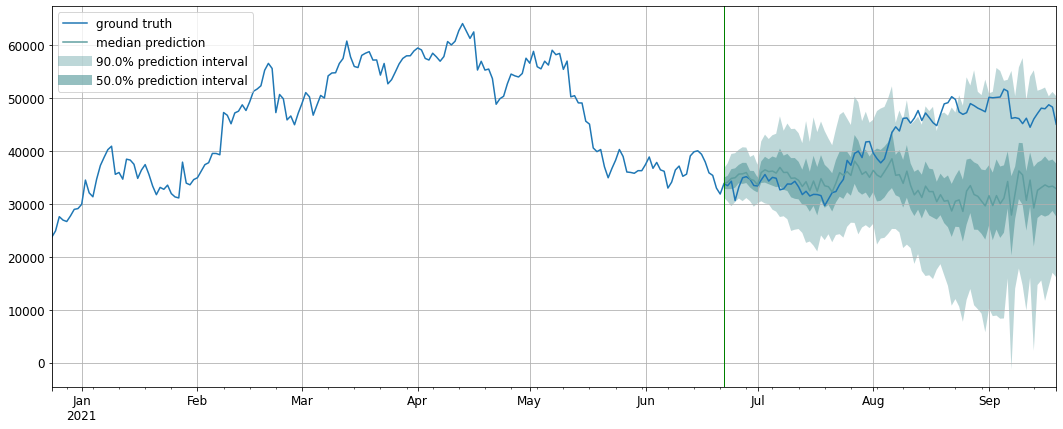

In [20]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = context_length + prediction_length
    prediction_intervals = (50.0, 90.0)
    legend = ["ground truth", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='cadetblue')
    plt.axvline(forecast_entry.start_date, color='g', lw=1) # end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.show();
    
plot_prob_forecasts(tss[0], forecasts[0])

In [21]:
#We can extract the mean and median values of our forecast as follows:
# first entry of the forecast list
forecast_entry = forecasts[0]
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [33884.406 34052.473 34701.438 34919.79  35638.117 35678.04  35887.62
 34716.273 34406.703 33632.914 35991.824 36471.37  36112.945 36129.926
 35865.043 36886.438 35810.17  36022.324 34843.727 34883.984 34386.69
 33201.285 34153.36  32383.055 34337.04  32388.184 34887.754 33435.367
 33266.742 32146.408 34196.97  35690.85  35411.105 36042.54  35324.38
 38267.277 37036.11  35618.145 36266.914 35082.473 36169.312 35361.645
 35295.867 35925.7   37044.31  38568.707 35323.023 35772.78  33842.31
 36177.12  33399.914 31906.977 32853.35  31290.758 32698.92  32371.846
 31857.945 31057.99  31845.594 30637.316 30044.568 28817.654 29880.701
 31037.803 28466.762 32793.32  33265.03  31484.611 31366.973 30235.781
 30054.549 32669.635 29786.236 31591.223 30562.41  31694.05  34289.81
 27970.17  32408.488 36752.15  36413.188 29720.908 34744.14  28828.352
 32992.86  33209.465 33077.613 32573.879 33708.812 32595.38 ]
0.5-quantile (median) of the future window:
 [33865.758 34118.4

In [22]:
!pip install -q hfda
import hfda

In [23]:
k_max = 15
D = hfda.measure(np.concatenate(high_values_at_9am.values), k_max)
print("Higuchi fractal dimension = %.2f" % D)

Higuchi fractal dimension = 1.47


In [24]:
bitcoin_minutes = bitcoin[["High"]].tail(1358)

D = hfda.measure(np.concatenate(bitcoin_minutes.values), k_max)
print("Higuchi fractal dimension = %.2f" %D)

Higuchi fractal dimension = 1.44


In [25]:
freq = "1min"           # the frequency of our data, now in minutes
context_length    = 180 # train on this number of days
prediction_length =  90 # predict these many days, these are removed from the end of the training data

data_list = [{"start": "2021-09-20 01:23:00", "target": bitcoin_minutes[c].values} for c in bitcoin_minutes.columns]
train_ds  = ListDataset(data_iter=data_list,freq=freq)

estimator = SimpleFeedForwardEstimator(num_hidden_dimensions=[50],
                                       freq=freq,
                                       context_length=context_length,
                                       prediction_length=prediction_length,
                                       distr_output=StudentTOutput(),
                                       trainer=Trainer(epochs=50,
                                                       learning_rate=1e-3,
                                                       num_batches_per_epoch=100,
                                                       patience=10))

predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:02<00:00, 47.32it/s, epoch=50/50, avg_epoch_loss=7.63]


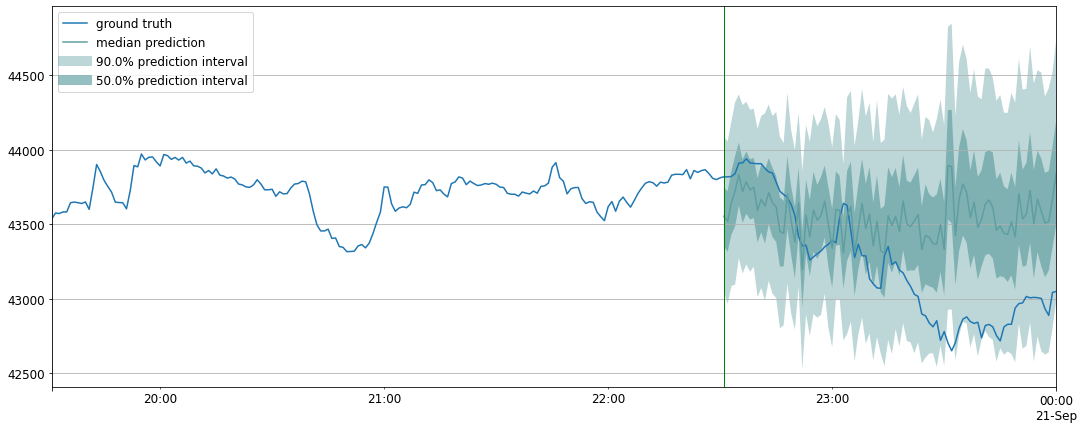

In [26]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,  # dataset
    predictor=predictor,  # predictor
    num_samples=2000,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

plot_prob_forecasts(tss[0], forecasts[0])